In this exercise, you will implement the `anomaly detection algorithm` and apply it to detect failing servers on a network.

In the second part, you will use `collaborative filtering` to build a recommender system for movies.

In [1]:
import os

import numpy  as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import scipy.io as sio
import scipy.optimize as opt
from scipy.io import loadmat
from scipy import stats

# Anomaly Detection

Implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server.

While your servers were operating, you collected $m = 307$ examples of how they were behaving, and thus have `an unlabeled dataset` $\{x^{(1)}, \dots, x^{(m)}\}$. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a `Gaussian model` to detect anomalous examples in your dataset.

You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies.

After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

We start this exercise by using a small dataset that is easy to visualize. Our example case consists of 2 network server statistics across several machines: the latency and throughput of each machine. 

In [2]:
path = "dataset/ex8data1.mat"
data = sio.loadmat(path)

X_train = data['X']
X_cv    = data['Xval']
y_cv    = data['yval'].reshape((-1,))

In [3]:
def plot_ori_data(data, axes=None):
    if axes == None:
        axes = plt.gca()
    
    axes.scatter(data[:, 0], data[:, 1], marker='x', s=30, linewidths=2)
    
    axes.set_xlabel('Latency (ms)')
    axes.set_ylabel('Throughput (mb/s)')

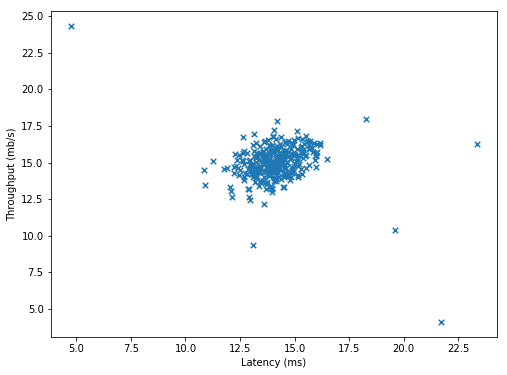

In [4]:
plt.figure(figsize=(8, 6))
plot_ori_data(X_train, plt.gca())

## Gaussian distribution

To perform anomaly detection, you will first need to `fit a model to the data's distribution`. 

Given a training set $\{x^{(1)}, \dots, x^{(m)} \}$ (where $x^{(i)} \in \mathbb{R}^n$ ), you want to estimate the Gaussian distribution for each of the features $x_i$ .

The Gaussiman distribution is given by

$$ p\left( x; \mu, \sigma^2 \right) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{\left(x-\mu\right)^2}{2\sigma^2}},$$
where $\mu$ is the mean and $\sigma^2$ is the variance.

一元正太分布,假设每个特征之间都是相互独立的，则给定样本的概率为：
$$p(x)=\prod_{j=1}^n p(x_j; u_j; \sigma_j^2) = \prod_{j=1}^n \frac{1}{\sqrt{2\pi \sigma_j}} \exp \left(- \frac{(x_j - u_j)^2}{2\sigma_j^2} \right) \quad (n为特征个数)$$

多元正太分布,每个特征之间不一定相互独立，则给定样本的概率为：
$$p(x)= \frac{1}{(2\pi)^{\frac{n}{2}} \left|\sum\right|^{\frac{1}{2}}} exp \left(-\frac{1}{2}(x-u)^T{\sum}^{-1}(x-u) \right) \quad (\sum为协方差矩阵)$$

## Estimating parameters for a Gaussian 

You can estimate the parameters $\left( \mu_i, \sigma_i^2 \right)$, of the $i^{th}$ feature by using the following equations. To estimate the mean, you will use: 

$$ \mu_i = \frac{1}{m} \sum_{j=1}^m x_i^{(j)},$$

and for the variance you will use:

$$ \sigma_i^2 = \frac{1}{m} \sum_{j=1}^m \left( x_i^{(j)} - \mu_i \right)^2.$$

###### estimate train_data distribution

In [5]:
def estimate_gaussian(X):
    mu  = np.mean(X, axis=0)
    var = np.var(X, axis=0)
    cov = np.cov(X.T)
    
    return mu, var, cov

In [6]:
mu, var, cov = estimate_gaussian(X_train)

###### predict train_data - `singal-value` gaussian probability

In [7]:
def singal_gaussian_predict(data, mu, var):
    predict = 1
    for (data_i, mu_i, var_i) in zip(data.T, mu.T, var.T):
        dist = stats.norm(mu_i, var_i)
        predict_i = dist.pdf(data_i)
        predict = predict * predict_i
    
    return predict

In [8]:
singal_pval = singal_gaussian_predict(X_train, mu, var)

###### predict train_data - `multi-value` gaussian probability

In [9]:
def multi_gaussian_predict(data, mu, cov):
    dist = stats.multivariate_normal(mu, cov)
    predict = dist.pdf(data)
    
    return predict

In [10]:
mutl_pval = multi_gaussian_predict(X_train, mu, cov)

## visualize Gaussian distribution

In [11]:
def plot_contour(data, model='singal', axes=None, best_epsilon=0, plot_error=False):
    if axes == None:
        axes = plt.gca()
    
    mu, var, cov = estimate_gaussian(data)
    X1, X2 = np.meshgrid(np.arange(data[:,0].min() * 0.2, data[:,0].max() * 1.2, 0.1), np.arange(data[:,1].min() * 0.2, data[:,1].max() * 1.2, 0.1))
    X_contour = np.c_[X1.ravel(), X2.ravel()]
    
    if model == "singal":
        pval = singal_gaussian_predict(X_contour, mu, var)
        pval_train = singal_gaussian_predict(data, mu, var)
    elif model == "multi":
        pval = multi_gaussian_predict(X_contour, mu, cov)
        pval_train = multi_gaussian_predict(data, mu, var)

    pval = pval.reshape(X1.shape)
    
    ct = axes.contour(X1, X2, pval, levels=10**(np.arange(-20., 1, 3)), zorder=100)
    axes.clabel(ct, inline=1, fontsize=12, fmt='%.2e', colors='k')
    
    if plot_error:
        outliers = pval_train < best_epsilon
        axes.plot(data[outliers, 0], data[outliers, 1], 'ro', ms=10, mfc='None', mew=2)

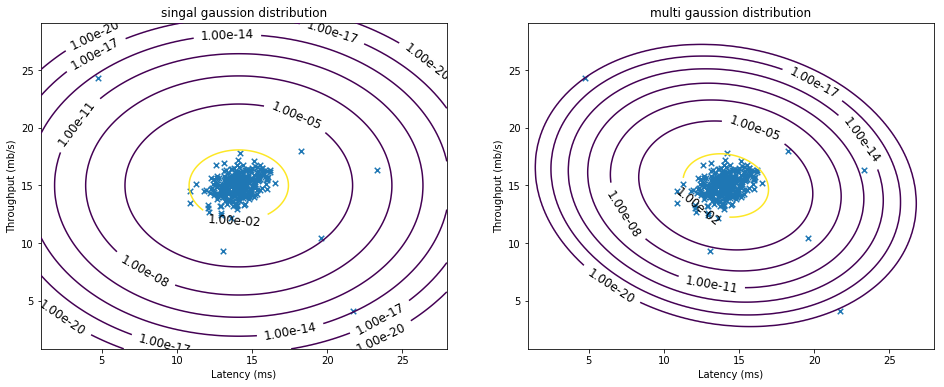

In [12]:
fig, axes = plt.subplots(1, 2, figsize=((16, 6)))
method = ['singal', 'multi']
for i in range(2):
    axes_i = axes.flatten()[i]
    
    plot_ori_data(X_train, axes=axes_i)
    plot_contour(X_train, method[i], axes=axes_i)
    axes_i.set_title(method[i] + " gaussion distribution")

## Selecting the threshold, ε

The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to `select a threshold based on a cross validation set`. In this part of the exercise, you will implement an algorithm to select the threshold $\varepsilon$ `using the $F_1$ score on a cross validation set`.

For this, we will use a cross validation set $\{ (x_{cv}^{(1)}, y_{cv}^{(1)}), \dots, (x_{cv}^{(m_{cv})}, y_{cv}^{(m_{cv})})\}$, where the label $y = 1$ corresponds to an anomalous example, and $y = 0$ corresponds to a normal example. For each cross validation example, we will compute $p\left( x_{cv}^{(i)}\right)$ -- `probabilities`.

If an example $x$ has a low probability $p(x) < \varepsilon$, then it is considered to be an `anomaly`.

The $F_1$ score is computed using precision ($prec$) and recall ($rec$):

$$ F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}, $$

You compute precision and recall by: 

$$ prec = \frac{tp}{tp + fp}  $$ 

$$ rec = \frac{tp}{tp + fn} $$

where: 

- $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.

-  $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
- $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve

In [13]:
from sklearn.metrics import f1_score, recall_score, precision_score

def select_threshold(train_data, val_data, val_result, model='singal'):
    best_epsilon  = 0
    best_F1_score = 0
    
    mu, var, cov = estimate_gaussian(train_data)
    
    if model == 'singal':
        pval = singal_gaussian_predict(val_data, mu, var)
    elif model == "multi":
        pval = multi_gaussian_predict(val_data, mu, cov)

    for epsilon in np.linspace(1.01*min(pval), max(pval), 1000):
        preds = pval < epsilon
        # preds = (pval < epsilon).astype('int')
        
        tp = np.sum(np.logical_and(preds == 1, val_result == 1)).astype(float)
        fp = np.sum(np.logical_and(preds == 1, val_result == 0)).astype(float)
        fn = np.sum(np.logical_and(preds == 0, val_result == 1)).astype(float)
        # precision = tp / (tp + fp)
        # recall = tp / (tp + fn)
        
        precision = precision_score(val_result, preds)
        recall = recall_score(val_result, preds)
        
        F1 = (2 * precision * recall) / (precision + recall)
        f1 = f1_score(val_result, preds)
        
        if F1 > best_F1_score:
            best_F1_score = F1
            best_epsilon = epsilon 
    
    return best_epsilon, best_F1_score

In [14]:
best_epsilon_singal, best_F1_score = select_threshold(X_train, X_cv, y_cv, 'singal')
print("best_epsilon_singal :", best_epsilon_singal)
print("best_F1_score :", best_F1_score)

best_epsilon_singal : 0.0004575950039152641
best_F1_score : 0.8750000000000001


In [15]:
best_epsilon_multi, best_F1_score = select_threshold(X_train, X_cv, y_cv, 'multi')
print("best_epsilon_multi :", best_epsilon_multi)
print("best_F1_score :", best_F1_score)

best_epsilon_multi : 9.045285962118505e-05
best_F1_score : 0.8750000000000001


You should see a value for `epsilon` of about 8.99e-05.

In [16]:
from sklearn.metrics import classification_report

In [17]:
mu, var, cov = estimate_gaussian(X_train)
pval = multi_gaussian_predict(X_cv, mu, cov)
y_pred = (pval <= best_epsilon_multi).astype('int')
print(classification_report(y_cv, y_pred))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       298
          1       1.00      0.78      0.88         9

avg / total       0.99      0.99      0.99       307



###### plot anomaly data-point

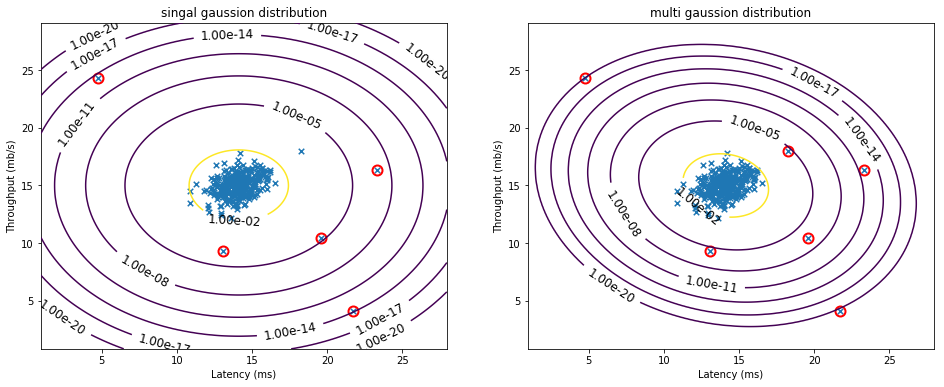

In [18]:
fig, axes = plt.subplots(1, 2, figsize=((16, 6)))
method = ['singal', 'multi']
best_epsilon = [best_epsilon_singal, best_epsilon_multi]

for i in range(2):
    axes_i = axes.flatten()[i]
    
    plot_ori_data(X_train, axes=axes_i)
    plot_contour(X_train, method[i], axes=axes_i, best_epsilon=best_epsilon[i], plot_error=True)
    axes_i.set_title(method[i] + " gaussion distribution")

###### fit data by `sklearn.covariance.EllipticEnvelope`

In [19]:
from sklearn.covariance import EllipticEnvelope

In [20]:
clf = EllipticEnvelope()
clf.fit(X_train)

EllipticEnvelope(assume_centered=False, contamination=0.1, random_state=None,
         store_precision=True, support_fraction=None)

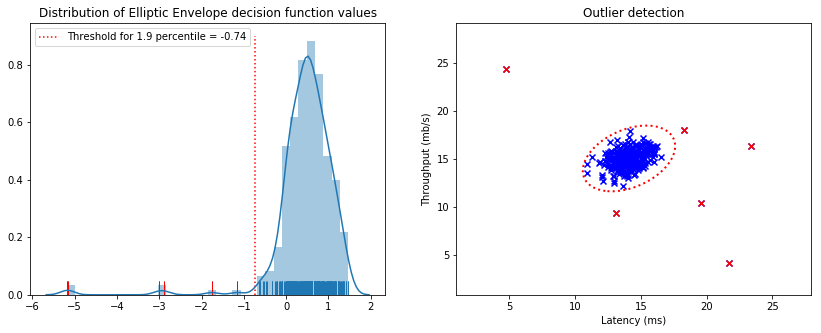

In [21]:
X1, X2 = np.meshgrid(np.arange(X_train[:,0].min() * 0.2, X_train[:,0].max() * 1.2, 0.1), np.arange(X_train[:,1].min() * 0.2, X_train[:,1].max() * 1.2, 0.1))
Z = clf.decision_function(np.c_[X1.ravel(), X2.ravel()])
Z = Z.reshape(X1.shape)

# Calculate the decision function and use threshold to determine outliers
y_pred = clf.decision_function(X_train).ravel()
percentile = 1.9
# best_epsilon_multi
threshold = np.percentile(y_pred, percentile)
outliers = y_pred < threshold

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

# Left plot
# Plot the decision function values
sns.distplot(y_pred, rug=True, ax=ax1)
# Plot the decision function values for the outliers in red
sns.distplot(y_pred[outliers], rug=True, hist=False, kde=False, norm_hist=True, color='r', ax=ax1)
ax1.vlines(threshold, 0, 0.9, colors='r', linestyles='dotted',
           label='Threshold for {} percentile = {}'.format(percentile, np.round(threshold, 2)))
ax1.set_title('Distribution of Elliptic Envelope decision function values');
ax1.legend(loc='best')


# Right plot
# Plot the observations
ax2.scatter(X_train[:,0], X_train[:,1], c='b', marker='x')
# Plot outliers
ax2.scatter(X_train[outliers][:,0], X_train[outliers][:,1], c='r', marker='x', linewidths=2)
# Plot decision boundary based on threshold
ax2.contour(X1, X2, Z, levels=[threshold], linewidths=2, colors='red', linestyles='dotted')
ax2.set_title("Outlier detection")
ax2.set_xlabel('Latency (ms)')
ax2.set_ylabel('Throughput (mb/s)');

## High dimensional dataset

The next cell will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers, but only some features indicate whether a point is an outlier. The script will use your code to estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$), evaluate the probabilities for both the training data `X` from which you estimated the Gaussian parameters, and do so for the the cross-validation set `Xval`. Finally, it will use `selectThreshold` to find the best threshold $\varepsilon$. 

You should see `a value epsilon of about 1.38e-18, and 117 anomalies found`.

In [22]:
path = "dataset/ex8data2.mat"
data = sio.loadmat(path)

X_train = data['X']
X_cv    = data['Xval']
y_cv    = data['yval'].reshape((-1,))

In [23]:
mu, var, cov = estimate_gaussian(X_train)
mutl_pval = multi_gaussian_predict(X_train, mu, cov)
best_epsilon, best_F1_score = select_threshold(X_train, X_cv, y_cv, 'multi')

anomaly_found = np.sum(mutl_pval < best_epsilon)
print("Anonmaly found:", anomaly_found)

Anonmaly found: 122


# Recommender systems

In this part of the exercise, you will implement `the collaborative filtering learning algorithm` and apply it to a dataset of movie ratings ([MovieLens 100k Dataset](https://grouplens.org/datasets/movielens/) from GroupLens Research). This dataset consists of ratings on a scale of 1 to 5. The dataset has $n_u = 943$ users, and $n_m = 1682$ movies.

## Movie ratings dataset

The next cell will load the dataset `ex8_movies.mat`, providing the variables `Y` and `R`.
The matrix `Y` (a `num_movies` $\times$ `num_users` matrix) stores the ratings $y^{(i,j)}$ (from 1 to 5). The matrix `R` is an binary-valued indicator matrix, where $R(i, j) = 1$ if user $j$ gave a rating to movie $i$, and $R(i, j) = 0$ otherwise. 

The objective of collaborative filtering is to `predict movie ratings for the movies that users have not yet rated`, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix `Y`, the following cell will compute the average movie rating for the first movie (Toy Story) and print its average rating.

Average rating for movie 1 (Toy Story): 4.520679 / 5


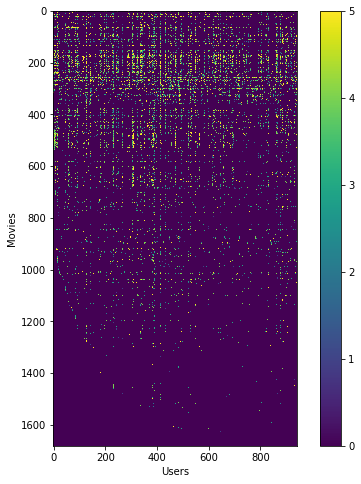

In [24]:
path = "dataset/ex8_movies.mat"
ori_data = sio.loadmat(path)

Y = ori_data['Y']
R = ori_data['R']

# Y is a 1682x943 matrix, containing ratings (1-5) of 
# 1682 movies on 943 users

# R is a 1682x943 matrix, where R(i,j) = 1 
# if and only if user j gave a rating to movie i

# From the matrix, we can compute statistics like average rating.
print('Average rating for movie 1 (Toy Story): %f / 5' % np.mean(Y[0, R[0, :]]))

# We can "visualize" the ratings matrix by plotting it with imshow
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.colorbar()
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid(False)

Throughout this part of the exercise, you will also be working with the matrices, `X` and `Theta`:

$$ \text{X} = 
\begin{bmatrix}
- \left(x^{(1)}\right)^T - \\
- \left(x^{(2)}\right)^T - \\
\vdots \\
- \left(x^{(n_m)}\right)^T - \\
\end{bmatrix}, \quad
\text{Theta} = 
\begin{bmatrix}
- \left(\theta^{(1)}\right)^T - \\
- \left(\theta^{(2)}\right)^T - \\
\vdots \\
- \left(\theta^{(n_u)}\right)^T - \\
\end{bmatrix}.
$$

The $i^{th}$ row of `X` corresponds to the feature vector $x^{(i)}$ for the $i^{th}$ movie

The $j^{th}$ row of `Theta` corresponds to one parameter vector $\theta^{(j)}$, for the $j^{th}$ user.

Both $x^{(i)}$ and $\theta^{(j)}$ are `n-dimensional vectors`. 

For the purposes of this exercise, you will use $n = 100$, and therefore, $x^{(i)} \in \mathbb{R}^{100}$ and $\theta^{(j)} \in \mathbb{R}^{100}$. Correspondingly, `X` is a $n_m \times 100$ matrix and `Theta` is a $n_u \times 100$ matrix.

## Collaborative filtering learning algorithm

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, \dots, x^{(n_m)}$ and $\theta^{(1)} , \dots, \theta^{(n_u)}$, where the model predicts the rating for movie $i$ by user $j$ as $y^{(i,j)} = \left( \theta^{(j)} \right)^T x^{(i)}$.

Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

Note that the parameters to the function (i.e., the values that you are trying to learn) are `X` and `Theta`. In order to use an off-the-shelf minimizer such as `scipy`'s `minimize` function, the cost function has been set up to unroll the parameters into a single vector called `params`. You had previously used the same vector unrolling method in the neural networks programming exercise.

### Collaborative filtering cost function

The collaborative filtering cost function (without regularization) is given by

$$
J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots,\theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right)^2
$$

Note that you should be accumulating the cost for user $j$ and movie $i$ only if `R[i,j] = 1`.

In [25]:
path = "dataset/ex8_movieParams.mat"
data = sio.loadmat(path)

X, theta, num_users, num_movies, num_features = \
            data['X'], data['Theta'], data['num_users'], \
            data['num_movies'], data['num_features']

In [26]:
def flatten_data(X, theta, Y, R, num_users, num_movies, num_features):
    X_temp = X[:num_movies, :num_features].ravel()
    theta_temp = theta[:num_users, :num_features].ravel()
    Y_temp = Y[:num_movies, :num_users]
    R_temp = R[:num_movies, :num_users]
    param = np.concatenate([X_temp, theta_temp])
    
    return param, Y_temp, R_temp

def unflatten_data(param, Y, R, num_users, num_movies, num_features):
    X_temp = param[: (num_movies * num_features)].reshape((num_movies, num_features))
    theta_temp = param[(num_movies * num_features):].reshape((num_users, num_features))
    Y_temp = Y.reshape((num_movies, num_users))
    R_temp = R.reshape((num_movies, num_users))
    
    return X_temp, theta_temp, Y_temp, R_temp

X, theta : 皆是所要优化的参数，所以要同时作为 cost_function 的第一个参数

In [27]:
def cost_function(param, Y, R, num_users, num_movies, num_features, lamd=0.0):
    X_temp, theta_temp, Y_temp, R_temp = \
        unflatten_data(param, Y, R, num_users, num_movies, num_features)

    err = ((X_temp @ theta_temp.T) - Y_temp) * R_temp
    cost = np.sum(np.power(err ,2)) / 2
    
    reg_item = lamd * np.sum(np.power(param, 2)) / 2
    
    cost_reg = cost + reg_item
    
    return cost_reg

In [28]:
t_num_users = 4
t_num_movies = 5
t_num_features = 3

param, t_Y, t_R = flatten_data(X, theta, Y, R, t_num_users, t_num_movies, t_num_features)
cost = cost_function(param, t_Y, t_R, t_num_users, t_num_movies, t_num_features)
print('cost without regularization:', cost)

cost without regularization: 22.224603725685675


After you have completed the function, the next cell will run your cost function. To help you debug your cost function, we have included set of weights that we trained on that.  You should expect to see an output of 22.22.

### Collaborative filtering gradient

 Note that `X_grad` should be a matrix of the same size as `X` and similarly, `Theta_grad` is a matrix of the same size as `Theta`. The gradients of the cost function is given by:

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} $$

In [29]:
def gradient(param, Y, R, num_users, num_movies, num_features, lamd=0.0):
    X_temp, theta_temp, Y_temp, R_temp = \
        unflatten_data(param, Y, R, num_users, num_movies, num_features)

    err = ((X_temp @ theta_temp.T) - Y_temp) * R_temp
    X_grad = err @ theta_temp
    theta_grad = err.T @ X_temp
    grad = np.concatenate((X_grad.ravel(), theta_grad.ravel()))
    
    reg_item = lamd * param
    
    reg_grad = grad + reg_item
    
    return reg_grad

In [30]:
grad = gradient(param, t_Y, t_R, t_num_users, t_num_movies, t_num_features)

In [31]:
grad_reg = gradient(param, t_Y, t_R, t_num_users, t_num_movies, t_num_features, 1.5)

assert X_grad.shape == X.shape

assert theta_grad.shape == theta.shape

### Gradient Check

In [32]:
def compute_numerical_gradient(J, param, e=1e-4):
    numgrad = np.zeros(param.shape)
    perturb = np.diag(e * np.ones(param.shape))
    for i in range(param.size):
        loss1 = J(param - perturb[:, i])
        loss2 = J(param + perturb[:, i])
        numgrad[i] = (loss2 - loss1)/(2*e)
    return numgrad

In [33]:
def check_cost_function_gradient(lamd=0.0):
    # Create small problem
    X_t = np.random.rand(4, 3)
    Theta_t = np.random.rand(5, 3)

    # Zap out most entries
    Y = np.dot(X_t, Theta_t.T)
    Y[np.random.rand(*Y.shape) > 0.5] = 0
    R = np.zeros(Y.shape)
    R[Y != 0] = 1
    
    # Run Gradient Checking
    X = np.random.randn(*X_t.shape)
    Theta = np.random.randn(*Theta_t.shape)
    num_movies, num_users = Y.shape
    num_features = Theta_t.shape[1]

    params = np.concatenate([X.ravel(), Theta.ravel()])
    
    numgrad = compute_numerical_gradient(
            lambda x: cost_function(x, Y, R, num_users, num_movies, num_features, lamd), params)
    
    grad = gradient(params, Y, R, num_users, num_movies, num_features, lamd)
    
    print(np.stack([numgrad, grad], axis=1))
    print('\nThe above two columns you get should be very similar.'
          '(Left-Your Numerical Gradient, Right-Analytical Gradient)')

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)
    print('If your cost function implementation is correct, then '
          'the relative difference will be small (less than 1e-9).')
    print('\nRelative Difference: %g' % diff)

In [34]:
check_cost_function_gradient()

[[ 2.02686733  2.02686733]
 [ 0.89873904  0.89873904]
 [ 0.90252037  0.90252037]
 [-0.68643656 -0.68643656]
 [ 0.55664677  0.55664677]
 [ 0.47026442  0.47026442]
 [ 1.76368947  1.76368947]
 [ 0.28694056  0.28694056]
 [ 0.75628407  0.75628407]
 [ 1.67693146  1.67693146]
 [ 1.23013812  1.23013812]
 [ 1.18517544  1.18517544]
 [-3.61867895 -3.61867895]
 [-2.09098497 -2.09098497]
 [ 0.87773078  0.87773078]
 [ 0.13972958  0.13972958]
 [-0.19287364 -0.19287364]
 [-0.21882642 -0.21882642]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.73507235  0.73507235]
 [-2.15524144 -2.15524144]
 [ 0.92824004  0.92824004]
 [ 0.          0.        ]
 [ 0.          0.        ]
 [ 0.          0.        ]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1e-9).

Relative Difference: 8.82436e-13


### Regularized cost function

$$ J(x^{(1)}, \dots, x^{(n_m)}, \theta^{(1)}, \dots, \theta^{(n_u)}) = \frac{1}{2} \sum_{(i,j):r(i,j)=1} \left( \left( \theta^{(j)} \right)^T x^{(i)} - y^{(i,j)} \right)^2 + \left( \frac{\lambda}{2} \sum_{j=1}^{n_u} \sum_{k=1}^{n} \left( \theta_k^{(j)} \right)^2  \right) + \left( \frac{\lambda}{2} \sum_{i=1}^{n_m} \sum_{k=1}^n \left(x_k^{(i)} \right)^2 \right) $$

In [35]:
t_num_users = 4
t_num_movies = 5
t_num_features = 3

param, t_Y, t_R = flatten_data(X, theta, Y, R, t_num_users, t_num_movies, t_num_features)
cost_reg = cost_function(param, t_Y, t_R, t_num_users, t_num_movies, t_num_features, lamd=1.5)
print("cost with regularization:", cost_reg)

cost with regularization: 31.34405624427422


### Regularized gradient

$$ \frac{\partial J}{\partial x_k^{(i)}} = \sum_{j:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)} - y^{(i,j)} \right) \theta_k^{(j)} + \lambda x_k^{(i)} $$

$$ \frac{\partial J}{\partial \theta_k^{(j)}} = \sum_{i:r(i,j)=1} \left( \left(\theta^{(j)}\right)^T x^{(i)}- y^{(i,j)} \right) x_k^{(j)} + \lambda \theta_k^{(j)} $$

###### check gradient_with_regularization

In [36]:
check_cost_function_gradient(1.5)

[[  0.6097595    0.6097595 ]
 [  0.70824795   0.70824795]
 [ -8.43351798  -8.43351799]
 [ -3.56645908  -3.56645908]
 [  6.10274723   6.10274723]
 [  6.77504449   6.77504449]
 [  1.66226208   1.66226208]
 [ -1.06994919  -1.06994919]
 [  1.82940408   1.82940408]
 [  6.95801101   6.95801101]
 [ -1.1718308   -1.1718308 ]
 [ -9.02211503  -9.02211503]
 [  0.42016949   0.42016949]
 [ -2.27668305  -2.27668305]
 [  3.98195468   3.98195468]
 [  0.16403408   0.16403408]
 [  1.52796552   1.52796552]
 [  0.65028426   0.65028426]
 [  1.08677098   1.08677098]
 [ -4.79178291  -4.79178291]
 [ -4.24045756  -4.24045756]
 [  1.19981421   1.19981421]
 [ -3.85508776  -3.85508776]
 [ -3.22483542  -3.22483542]
 [-10.79614974 -10.79614974]
 [ -3.07552847  -3.07552847]
 [  6.95696102   6.95696102]]

The above two columns you get should be very similar.(Left-Your Numerical Gradient, Right-Analytical Gradient)
If your cost function implementation is correct, then the relative difference will be small (less than 1

## Learning movie recommendations

After you have finished implementing the collaborative filtering cost function and gradient, you can now start training your algorithm to make movie recommendations for yourself.

In the next cell, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. 

The list of all movies and their number in the dataset can be found listed in the file `Data/movie_idx.txt`.

In [37]:
def loadMovieList():
    """
    Reads the fixed movie list in movie_ids.txt and returns a list of movie names.

    Returns
    -------
    movieNames : list
        A list of strings, representing all movie names.
    """
    # Read the fixed movieulary list
    with open(os.path.join('dataset', 'movie_ids.txt'),  encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
        
    return movieNames

In [38]:
#  Before we will train the collaborative filtering model, we will first
#  add ratings that correspond to a new user that we just observed. This
#  part of the code will also allow you to put in your own ratings for the
#  movies in our dataset!
movieList = loadMovieList()
n_m = len(movieList)

#  Initialize my ratings
my_ratings = np.zeros(n_m)

# Check the file movie_idx.txt for id of each movie in our dataset
# For example, Toy Story (1995) has ID 1, so to rate it "4", you can set
# Note that the index here is ID-1, since we start index from 0.
my_ratings[0] = 4

# Or suppose did not enjoy Silence of the Lambs (1991), you can set
my_ratings[97] = 2

# We have selected a few movies we liked / did not like and the ratings we
# gave are as follows:
my_ratings[6] = 3
my_ratings[11]= 5
my_ratings[53] = 4
my_ratings[63] = 5
my_ratings[65] = 3
my_ratings[68] = 5
my_ratings[182] = 4
my_ratings[225] = 5
my_ratings[354] = 5

print('New user ratings:')
print('-----------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d stars: %s' % (my_ratings[i], movieList[i]))

New user ratings:
-----------------
Rated 4 stars: Toy Story (1995)
Rated 3 stars: Twelve Monkeys (1995)
Rated 5 stars: Usual Suspects, The (1995)
Rated 4 stars: Outbreak (1995)
Rated 5 stars: Shawshank Redemption, The (1994)
Rated 3 stars: While You Were Sleeping (1995)
Rated 5 stars: Forrest Gump (1994)
Rated 2 stars: Silence of the Lambs, The (1991)
Rated 4 stars: Alien (1979)
Rated 5 stars: Die Hard 2 (1990)
Rated 5 stars: Sphere (1998)


## Recommendations

In [39]:
def normalizeRatings(Y, R):
    """
    Preprocess data by subtracting mean rating for every movie (every row).

    Parameters
    ----------
    Y : array_like
        The user ratings for all movies. A matrix of shape (num_movies x num_users).

    R : array_like
        Indicator matrix for movies rated by users. A matrix of shape (num_movies x num_users).

    Returns
    -------
    Ynorm : array_like
        A matrix of same shape as Y, after mean normalization.

    Ymean : array_like
        A vector of shape (num_movies, ) containing the mean rating for each movie.
    """
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros(Y.shape)

    for i in range(m):
        idx = R[i, :] == 1
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]

    return Ynorm, Ymean

In [40]:
#  Now, you will train the collaborative filtering model on a movie rating 
#  dataset of 1682 movies and 943 users

#  Load data
data = sio.loadmat(os.path.join('dataset', 'ex8_movies.mat'))
Y, R = data['Y'], data['R']

#  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies by 
#  943 users

#  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
#  rating to movie i

#  Add our own ratings to the data matrix
Y = np.hstack([my_ratings[:, None], Y])
R = np.hstack([(my_ratings > 0)[:, None], R])
print(Y.shape)

#  Normalize Ratings
Ynorm, Ymean = normalizeRatings(Y, R)

#  Useful Values
num_movies, num_users = Y.shape
num_features = 50

# Set Initial Parameters (Theta, X)
X = np.random.rand(num_movies, num_features)
Theta = np.random.rand(num_users, num_features)

initial_parameters = np.concatenate([X.ravel(), Theta.ravel()])

# Set options for scipy.optimize.minimize
options = {'maxiter': 2000}

# Set Regularization
lambda_ = 10
res = opt.minimize(
    fun = cost_function,
    x0 = initial_parameters,
    args = (Ynorm, R, num_users, num_movies, num_features, lambda_),
    method = 'TNC',
    jac = gradient,
    options=options)
theta = res.x

# Unfold the returned theta back into U and W
X = theta[:num_movies*num_features].reshape(num_movies, num_features)
Theta = theta[num_movies*num_features:].reshape(num_users, num_features)

print('Recommender system learning completed.')

(1682, 944)
Recommender system learning completed.


In [41]:
res

     fun: 34613.38580798972
     jac: array([-3.38464450e-07, -3.67513608e-07, -1.02355669e-06, ...,
       -1.72954807e-07,  2.63170964e-07,  4.34901990e-08])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 982
     nit: 52
  status: 1
 success: True
       x: array([-0.10740713,  0.15251662,  0.32385702, ...,  0.11718177,
        0.2117106 , -0.30616561])

In [42]:
def loadMovieList():
    """
    Reads the fixed movie list in movie_ids.txt and returns a list of movie names.

    Returns
    -------
    movieNames : list
        A list of strings, representing all movie names.
    """
    # Read the fixed movieulary list
    with open(os.path.join('dataset', 'movie_ids.txt'),  encoding='ISO-8859-1') as fid:
        movies = fid.readlines()

    movieNames = []
    for movie in movies:
        parts = movie.split()
        movieNames.append(' '.join(parts[1:]).strip())
    return movieNames

In [43]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

movieList = loadMovieList()

ix = np.argsort(my_predictions)[::-1]

print('Top recommendations for you:')
print('----------------------------')
for i in range(20):
    j = ix[i]
    print('Predicting rating %.1f for movie %s' % (my_predictions[j], movieList[j]))

print('\nOriginal ratings provided:')
print('--------------------------')
for i in range(len(my_ratings)):
    if my_ratings[i] > 0:
        print('Rated %d for %s' % (my_ratings[i], movieList[i]))

Top recommendations for you:
----------------------------
Predicting rating 5.0 for movie Great Day in Harlem, A (1994)
Predicting rating 5.0 for movie Saint of Fort Washington, The (1993)
Predicting rating 5.0 for movie Star Kid (1997)
Predicting rating 5.0 for movie Aiqing wansui (1994)
Predicting rating 5.0 for movie Someone Else's America (1995)
Predicting rating 5.0 for movie They Made Me a Criminal (1939)
Predicting rating 5.0 for movie Entertaining Angels: The Dorothy Day Story (1996)
Predicting rating 5.0 for movie Marlene Dietrich: Shadow and Light (1996)
Predicting rating 5.0 for movie Prefontaine (1997)
Predicting rating 5.0 for movie Santa with Muscles (1996)
Predicting rating 4.6 for movie Pather Panchali (1955)
Predicting rating 4.6 for movie Shawshank Redemption, The (1994)
Predicting rating 4.6 for movie Star Wars (1977)
Predicting rating 4.5 for movie Maya Lin: A Strong Clear Vision (1994)
Predicting rating 4.5 for movie Close Shave, A (1995)
Predicting rating 4.5 for 